<a href="https://colab.research.google.com/github/elizabethts/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import cycle, islice

In [2]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [3]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=62.45887146973449, pvalue=2.736707531571271e-14)


In [4]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [5]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head(20)

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [6]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [8]:
df['hours-per-week']

0        40
1        13
2        40
3        40
4        40
5        40
6        16
7        45
8        50
9        40
10       80
11       40
12       30
13       50
14       40
15       45
16       35
17       40
18       50
19       45
20       60
21       20
22       40
23       40
24       40
25       40
26       40
27       60
28       80
29       40
         ..
32531    99
32532    60
32533    50
32534    39
32535    35
32536    55
32537    46
32538    45
32539    10
32540    40
32541    32
32542    25
32543    48
32544    30
32545    20
32546    40
32547    40
32548    60
32549    40
32550    50
32551    40
32552    45
32553    11
32554    40
32555    40
32556    38
32557    40
32558    40
32559    20
32560    40
Name: hours-per-week, Length: 32561, dtype: int64

In [9]:
cut_points = [0,9,19,29,39,49,1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['hours-per-week-categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours-per-week-categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [10]:
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [11]:
df['hours-per-week-categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours-per-week-categories, dtype: int64

In [12]:
df = df.sort_values(by='hours-per-week-categories',ascending=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours-per-week-categories
31290,55,Self-emp-not-inc,41938,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,8,United-States,<=50K,0-9
5172,32,NaN,134886,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,2,United-States,>50K,0-9
22928,17,NaN,332666,10th,6,Never-married,NaN,Own-child,White,Female,0,0,4,United-States,<=50K,0-9
7902,35,Private,359131,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,7298,0,8,NaN,>50K,0-9
6604,41,Private,406603,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,6,Iran,<=50K,0-9


In [13]:
contingency_table = pd.crosstab(df['sex'],df['hours-per-week-categories'], margins=True)
contingency_table

hours-per-week-categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [14]:
female_count = contingency_table.iloc[0][0:6].values
female_count

array([ 235,  671, 1287, 1914, 5636, 1028])

In [15]:
male_count = contingency_table.iloc[1][0:6].values
male_count

array([  223,   575,  1105,  1753, 12700,  5434])

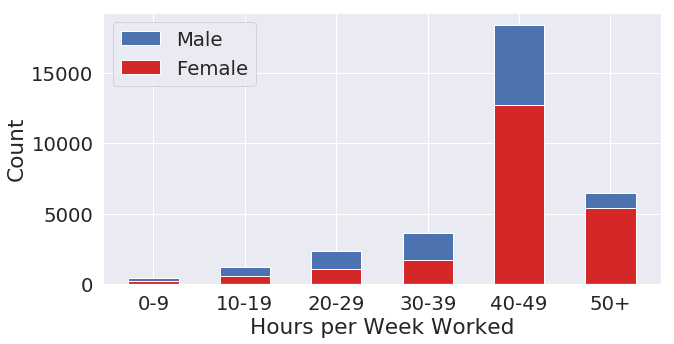

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
categories = ["0-9","10-19","20-29","30-39","40-49","50+"]
p1 = plt.bar(categories, male_count, 0.55, color='#d62728')
p2 = plt.bar(categories, female_count, 0.55, bottom=male_count)
plt.legend((p2[0], p1[0]), ('Male', 'Female'))
plt.xlabel('Hours per Week Worked')
plt.ylabel('Count')
plt.show()

In [17]:
#get sums
row_sums = contingency_table.iloc[0:2,6].values
col_sums = contingency_table.iloc[2,0:6].values

print(row_sums)
print(col_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [18]:
total = contingency_table.loc['All', 'All']
total

32561

In [19]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
np.array(expected)

array([[  151.50388502,   412.16995793,   791.26046497,  1213.02346365,
         6065.44811277,  2137.59411566],
       [  306.49611498,   833.83004207,  1600.73953503,  2453.97653635,
        12270.55188723,  4324.40588434]])

In [20]:
observed = pd.crosstab(df['sex'], df['hours-per-week-categories']).values
observed

array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

In [21]:
#calculate chi squared
chi_squared = ((observed-expected)**2/expected).sum()
print(f'Chi-squared: {chi_squared}')

Chi-squared: 2287.190943926107


In [22]:
#calculate degrees of freedom
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f'Degrees of Freedom: {dof}')


Degrees of Freedom: 5


In [23]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 2287.190943926107
P-value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [24]:
#confidence interval = [lower bound, upper bound]

coinflips = np.random.binomial(n=1 , p=0.5 , size=100)
print(coinflips)

[1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0
 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1]


In [25]:
coinflips.mean()

0.49

In [26]:
stats.ttest_1samp(coinflips, 0.5)

Ttest_1sampResult(statistic=-0.19903729886263904, pvalue=0.8426417731724416)

In [27]:
coinflips_100 = np.random.binomial(n=1 , p=0.5 , size=100)
coinflips_1000 = np.random.binomial(n=1 , p=0.5 , size=1000)

print('100 coinflips mean: ', coinflips_100.mean())
print('1000 coinflips mean: ', coinflips_1000.mean())

print('100 coinflips std: ', coinflips_100.std())
print('1000 coinflips std: ', coinflips_1000.std())

print('100 coinflips standard error: ', stats.sem(coinflips_100))
print('1000 coinflips standard error: ', stats.sem(coinflips_1000))

100 coinflips mean:  0.48
1000 coinflips mean:  0.516
100 coinflips std:  0.49959983987187184
1000 coinflips std:  0.499743934430424
100 coinflips standard error:  0.05021167315686782
1000 coinflips standard error:  0.015811198373114985


In [28]:
coinflips_100.std() / np.sqrt(100-1)


0.05021167315686783

In [29]:
coinflips_1000.std() / np.sqrt(1000-1)

0.015811198373114985

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.5}, {:.5}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [31]:
report_confidence_interval(confidence_interval(coinflips_100))

'our mean lies in the interval [0.38037, 0.57963]'

In [32]:
report_confidence_interval(confidence_interval(coinflips_1000))

'our mean lies in the interval [0.48497, 0.54703]'

In [33]:
stats.t.ppf(0.05,5)

-2.0150483726691575

In [34]:
coinflips_1M = np.random.binomial(1, 0.5, 1000000)
report_confidence_interval(confidence_interval(coinflips_1M))

'our mean lies in the interval [0.49898, 0.50094]'

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
import random

In [36]:
voting_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

#define column headers
column_headers = ('party','handicapped-infants', 'water-project-cost-sharing'
               , 'adoption-of-the-budget-resolution', 'physician-fee-freeze', 'el-salvador-aid'
               , 'religious-groups-in-schools', 'anti-satellite-test-ban'
               , 'aid-to-nicaraguan-contras', 'mx-missile', 'immigration'
               , 'synfuels-corporation-cutback', 'education-spending'
               , 'superfund-right-to-sue', 'crime', 'duty-free-exports'
               , 'export-administration-act-south-africa')

#create dataframe
df = pd.read_csv(voting_url, names=column_headers)

#clean values
yes_no = {'y': 1, 'n': 0, '?': np.nan}
df = df.replace(yes_no)

df.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [37]:
df.values.T

array([['republican', 'republican', 'democrat', ..., 'republican',
        'republican', 'republican'],
       [0.0, 0.0, nan, ..., 0.0, 0.0, 0.0],
       [1.0, 1.0, 1.0, ..., nan, 0.0, 1.0],
       ...,
       [1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, nan],
       [1.0, nan, 0.0, ..., 1.0, 1.0, 0.0]], dtype=object)

In [0]:
def clean_nans(array):
  return array[~np.isnan(array)]

def confidence_interval_dataframe(df):
  
  confidence_intervals = []
  
  #turn dataframe into a numpy array
  #transpose values
  df = df.values.T
  
  #clean nan values
  for col in df:
    cleaned_col = clean_nans(col)
    
    #calculate confidence interval for each issue
    confidence_intervals.append(confidence_interval(cleaned_col))
    
  confidence_intervals = pd.DataFrame(confidence_intervals, columns= ['mean','lower','upper'])

  
  return confidence_intervals
  

In [39]:
#drop parties from the dataframe
only_votes = df.drop('party', axis='columns')

confidence_interval_df = confidence_interval_dataframe(only_votes)
confidence_interval_df.head()

,mean,lower,upper
0,0.442080,0.394560,0.489600
1,0.503876,0.453841,0.553911
2,0.596698,0.549815,0.643581
3,0.417453,0.370323,0.464582
4,0.504762,0.456750,0.552774


In [0]:
#find margin of error
confidence_interval_df['MOE'] = confidence_interval_df['mean'] - confidence_interval_df['lower']

In [41]:
print(confidence_interval_df.shape)
confidence_interval_df

(16, 4)


,mean,lower,upper,MOE
0,0.442080,0.394560,0.489600,0.047520
1,0.503876,0.453841,0.553911,0.050035
2,0.596698,0.549815,0.643581,0.046883
3,0.417453,0.370323,0.464582,0.047129
4,0.504762,0.456750,0.552774,0.048012
5,0.641509,0.595678,0.687341,0.045831
6,0.567696,0.520181,0.615211,0.047515
7,0.576190,0.528737,0.623644,0.047453
8,0.501211,0.452788,0.549633,0.048422
9,0.504673,0.457116,0.552230,0.047557


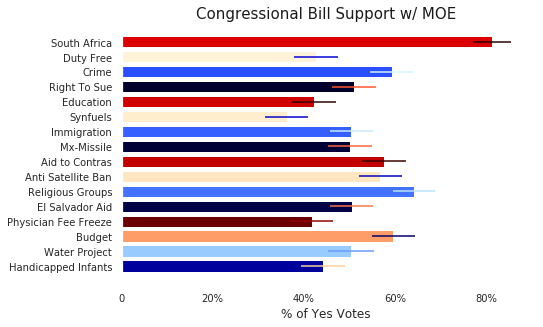

In [127]:
#figure
fig, ax = plt.subplots(figsize=(8, 5))
ax.patch.set(facecolor='white')

#data, error, and labels
means = confidence_interval_df['mean']
error = confidence_interval_df['MOE']
x = np.linspace(0, confidence_interval_df.shape[0], confidence_interval_df.shape[0])
issues = ['Handicapped Infants','Water Project',
                          'Budget','Physician Fee Freeze', 'El Salvador Aid',
                          'Religious Groups','Anti Satellite Ban',
                          'Aid to Contras','Mx-Missile','Immigration',
                          'Synfuels', 'Education', 'Right To Sue','Crime','Duty Free',
                          'South Africa']
xlabels = ['0','20%', '40%', '60%', '80%']

#Playing w/ colors
#Matplotlib Named Colors: https://matplotlib.org/2.0.0/examples/color/named_colors.html
# colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple','pink',
#           'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink',
#           'red', 'orange']

#how to cycle through a repeating list
#you will need to import cycle, islice from itertools
#colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))

#prop cycles
#prop_cycle = plt.rcParams['axes.prop_cycle']  
#colors = prop_cycle.by_key()['color']

#colormap options: https://matplotlib.org/users/colormaps.html
color = cm.flag(np.linspace(.8,.2, 40)) 
err_colors = cm.flag(np.linspace(.2,.8, 40))


#plot and set labels
ax.barh(x, means, xerr=error, color = color, ecolor = err_colors)
ax.set_xlabel("% of Yes Votes", fontsize = 12)
ax.set_xticks([0,0.2,0.4,0.6,0.8])
#ax.set_yticks([0,1.1,2.15,3.2,4.25,5.3,6.4,7.45,8.5,9.55,10.7,11.7,12.75,13.85,15,16])
ax.set_yticks(x)
ax.set_yticklabels(issues, fontsize = 10)
ax.set_xticklabels(xlabels, fontsize = 10)

#ax.set_xlabel(issues)
ax.set_title('Congressional Bill Support w/ MOE', color='k', fontsize = 15)
ax.yaxis.grid(False)


# Save the figure and show
# Different style sheets: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('fast')
plt.tight_layout()
plt.xticks(rotation=0)
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()



Null hypothesis: There is equal support for religious groups in schools.

Alternative hypothesis: There is ~60% support for religious groups in schools.

What does the confidence interval tell us??

If we repeat this exp 100 times, we can say that mean will lie within 4.58% of 64% support for religious groups in schools 95% of the time.


In [45]:
# #not using this, sampling
# def sample_100(df_column):
#   means= []
#   for i in range(100):
#     sample = df_column.sample(40, replace = True)
#     means.append(sample.mean())
#   return means


# religious_group_sample = sample_100(df['religious-groups-in-schools'])
# print(religious_group_sample)

[0.631578947368421, 0.625, 0.6153846153846154, 0.717948717948718, 0.6, 0.625, 0.5384615384615384, 0.6, 0.717948717948718, 0.725, 0.7692307692307693, 0.6052631578947368, 0.5897435897435898, 0.48717948717948717, 0.575, 0.675, 0.65, 0.6666666666666666, 0.5641025641025641, 0.6842105263157895, 0.7027027027027027, 0.5263157894736842, 0.6388888888888888, 0.65, 0.6486486486486487, 0.525, 0.717948717948718, 0.631578947368421, 0.6, 0.6923076923076923, 0.725, 0.5128205128205128, 0.5384615384615384, 0.5128205128205128, 0.6410256410256411, 0.7, 0.6410256410256411, 0.5384615384615384, 0.575, 0.6216216216216216, 0.6, 0.6666666666666666, 0.5128205128205128, 0.6578947368421053, 0.6, 0.5263157894736842, 0.6578947368421053, 0.7435897435897436, 0.6, 0.625, 0.7894736842105263, 0.6842105263157895, 0.525, 0.6, 0.5, 0.5277777777777778, 0.7368421052631579, 0.575, 0.6923076923076923, 0.65, 0.675, 0.6052631578947368, 0.6, 0.55, 0.7, 0.675, 0.65, 0.6, 0.6410256410256411, 0.65, 0.775, 0.75, 0.7435897435897436, 0.6

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)